In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_image_tensor(path):
    """
    Load image and convert to normalized torch tensor with gradients enabled.
    Returns tensor of shape (3, H, W) with values in [0, 1].
    """
    # Load with matplotlib to ensure consistent color handling
    image = plt.imread(path)
    image_tensor = torch.from_numpy(image).float()
    
    # Handle different image formats
    if len(image_tensor.shape) == 2:  # Grayscale
        image_tensor = image_tensor.unsqueeze(0).repeat(3, 1, 1)
    elif len(image_tensor.shape) == 3:
        if image_tensor.shape[2] == 4:  # RGBA
            image_tensor = image_tensor[:, :, :3]
        image_tensor = image_tensor.permute(2, 0, 1)
    
    # Normalize
    if image_tensor.max() > 1.0:
        image_tensor = image_tensor / 255.0
        
    image_tensor.requires_grad_(True)
    return image_tensor

image_tensor = load_image_tensor('/Users/michaelbertagna/git/Galaxy-Deconv/tutorials/example_snr300.png')

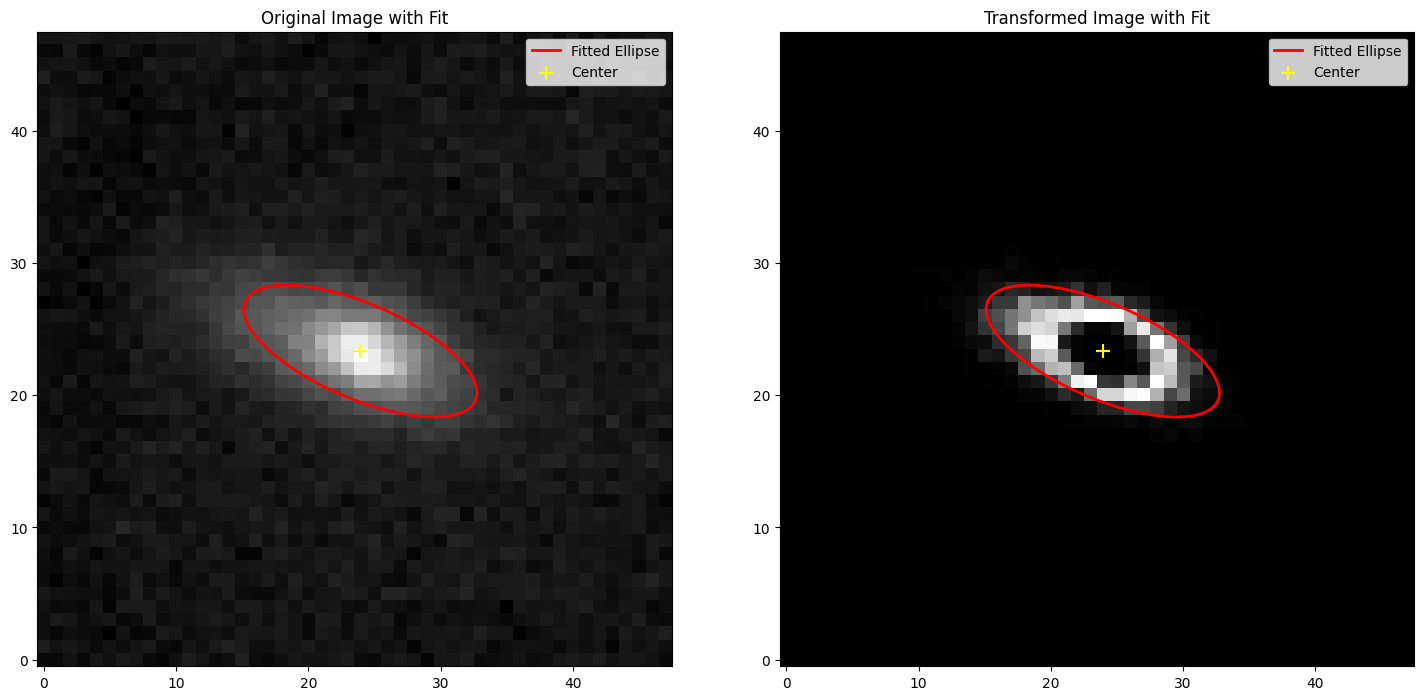

In [ ]:
def sigmoid_mask(x: torch.Tensor, 
                   peak_pos: float = 0.4, 
                   sharpness: float = 20.0) -> torch.Tensor:
    """
    Differentiable nonlinear transformation for galaxy edge processing.
    Maintains low values, amplifies mid-range, suppresses highs.
    """
    scaled_x = sharpness * (x - peak_pos)
    return x * torch.sigmoid(scaled_x) * (1 - torch.sigmoid(scaled_x - 2.0))

def mask_to_points_and_weights_full(mask):
    """
    Converts a masked image tensor into points with associated weights.
    """
    H, W = mask.shape
    x_coords, y_coords = torch.meshgrid(torch.arange(H), torch.arange(W))
    points = torch.stack((x_coords.flatten(), y_coords.flatten()), dim=1).float()
    weights = mask.flatten()
    return points, weights

def weighted_ellipse_fit(points, weights):
    """
    Fit an ellipse to weighted points using SVD, avoiding in-place operations.
    
    Parameters:
        points (Tensor): Nx2 tensor of (x, y) points
        weights (Tensor): N-element tensor of weights
    
    Returns:
        params (Tensor): The ellipse parameters [A, B, C, D, E, F]
    """
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    
    # Construct the design matrix
    D = torch.stack((x**2, x*y, y**2, x, y, torch.ones_like(x)), dim=1)
    
    # Create diagonal weight matrix and apply weights
    W = torch.diag_embed(weights)
    D_weighted = torch.matmul(W, D)
    
    # Solve using SVD
    U, S, V = torch.svd(D_weighted)
    params = V[:, -1]
    
    # Normalize parameters WITHOUT in-place operation
    norm = torch.norm(params)
    params = params / (norm + 1e-8)  # Add small epsilon for numerical stability
    
    return params

def plot_galaxy_ellipse(image: torch.Tensor, params: torch.Tensor, ax=None):
    """
    Plot the galaxy image with fitted ellipse overlay.
    
    Parameters:
        image (torch.Tensor): Original galaxy image
        params (torch.Tensor): Fitted ellipse parameters [A, B, C, D, E, F]
        ax (matplotlib.axes.Axes, optional): The axes to plot on
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the galaxy image
    ax.imshow(image.cpu().numpy(), cmap='gray', origin='lower')
    
    # Convert parameters to tensors
    A, B, C, D, E, F = [torch.tensor(x) for x in params.tolist()]
    
    # Calculate ellipse center
    denominator = 4*A*C - B**2
    cx = (B*E - 2*C*D) / denominator
    cy = (B*D - 2*A*E) / denominator
    
    # Calculate rotation angle and semi-axes
    theta = 0.5 * torch.atan2(B, A - C)
    cos_t = torch.cos(theta)
    sin_t = torch.sin(theta)
    
    # Calculate semi-axes lengths
    a_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*cos_t**2 + B*cos_t*sin_t + C*sin_t**2)
    b_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*sin_t**2 - B*cos_t*sin_t + C*cos_t**2)
    
    a = torch.sqrt(torch.abs(a_squared))
    b = torch.sqrt(torch.abs(b_squared))
    
    # Generate ellipse points
    t = torch.linspace(0, 2*np.pi, 200)
    x_circle = a * torch.cos(t)
    y_circle = b * torch.sin(t)
    
    # Rotate and translate
    R = torch.tensor([[cos_t, -sin_t],
                     [sin_t, cos_t]])
    points = torch.stack([x_circle, y_circle])
    rotated_points = R @ points
    x = rotated_points[0] + cx
    y = rotated_points[1] + cy
    
    # Plot ellipse overlay
    ax.plot(y.numpy(), x.numpy(), 'r-', label='Fitted Ellipse', linewidth=2)
    ax.scatter(cy.item(), cx.item(), color='yellow', marker='+', s=100, label='Center')
    
    # Customize plot
    ax.set_title('Galaxy Image with Fitted Ellipse')
    ax.legend()
    return ax

def ellipse_params(image_tensor):
    gray_image = torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device))
    masked_image = sigmoid_mask(gray_image)
    points, weights = mask_to_points_and_weights_full(masked_image)
    params = weighted_ellipse_fit(points, weights)

    # Convert parameters to tensors
    A, B, C, D, E, F = [torch.tensor(x) for x in params.tolist()]
    
    # Calculate ellipse center
    denominator = 4*A*C - B**2
    cx = (B*E - 2*C*D) / denominator
    cy = (B*D - 2*A*E) / denominator
    
    # Calculate rotation angle and semi-axes
    theta = 0.5 * torch.atan2(B, A - C)
    cos_t = torch.cos(theta)
    sin_t = torch.sin(theta)
    
    # Calculate semi-axes lengths
    a_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*cos_t**2 + B*cos_t*sin_t + C*sin_t**2)
    b_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*sin_t**2 - B*cos_t*sin_t + C*cos_t**2)
    
    a = torch.sqrt(torch.abs(a_squared))
    b = torch.sqrt(torch.abs(b_squared))

    return (cx, cy), theta, a, b

import torch.nn.functional as F

def ellipse_loss(output_params, target_params, center_weight=1.0, angle_weight=1.0, axis_weight=1.0):
    """
    Computes loss between output and target ellipse parameters.
    
    Args:
    - output_params: Tuple (cx_out, cy_out, theta_out, a_out, b_out)
    - target_params: Tuple (cx_tgt, cy_tgt, theta_tgt, a_tgt, b_tgt)
    - center_weight: Weight for center loss
    - angle_weight: Weight for angle loss
    - axis_weight: Weight for axis loss
    
    Returns:
    - Total loss (scalar tensor)
    """
    # Unpack parameters
    (cx_out, cy_out, theta_out, a_out, b_out) = output_params
    (cx_tgt, cy_tgt, theta_tgt, a_tgt, b_tgt) = target_params
    
    # Center loss (L2 loss)
    center_loss = F.mse_loss(torch.stack([cx_out, cy_out]), torch.stack([cx_tgt, cy_tgt]))
    
    # Angle loss (MSE)
    angle_loss = F.mse_loss(theta_out, theta_tgt)
    
    # Axis loss (L1 loss)
    axis_loss = F.l1_loss(a_out, a_tgt) + F.l1_loss(b_out, b_tgt)
    
    # Weighted sum of losses
    total_loss = center_weight * center_loss + angle_weight * angle_loss + axis_weight * axis_loss
    
    return total_loss

def process_and_fit_galaxy(image: torch.Tensor):
    """
    Complete pipeline for processing a galaxy image and fitting an ellipse.
    
    Parameters:
        image (torch.Tensor): Input galaxy image tensor
        
    Returns:
        params (torch.Tensor): Fitted ellipse parameters
        fig (matplotlib.figure.Figure): Figure with the result
    """
    # Apply value transform to enhance edges
    transformed = sigmoid_mask(image)
    
    # Convert to points and weights
    points, weights = mask_to_points_and_weights_full(transformed)
    
    # Fit ellipse
    params = weighted_ellipse_fit(points, weights)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image with fit
    plot_galaxy_ellipse(image, params, ax1)
    ax1.set_title('Original Image with Fit')
    
    # Transformed image with fit
    plot_galaxy_ellipse(transformed, params, ax2)
    ax2.set_title('Transformed Image with Fit')
    
    plt.tight_layout()
    return params, fig

galaxy_image = torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device))

# Example usage:
# Assuming 'galaxy_image' is your input tensor:
params, fig = process_and_fit_galaxy(galaxy_image)
plt.show()

In [ ]:
x = galaxy_image
x.requires_grad_(True)
y = weighted_ellipse_fit(*mask_to_points_and_weights_full(sigmoid_mask(x)))  # Differentiable operation
print(y)
y.sum().backward()

print(x.shape, x.grad.shape)
print(x.grad)

tensor([-8.9112e-04, -6.3751e-04, -2.8441e-04,  5.6861e-02,  2.8493e-02,
        -9.9797e-01], grad_fn=<DivBackward0>)
torch.Size([48, 48]) torch.Size([48, 48])
tensor([[ 2.0156e-09, -3.3836e-08, -9.5646e-07,  ..., -1.6189e-05,
         -6.7831e-06, -9.5720e-07],
        [ 1.0541e-05,  4.3461e-07, -1.0073e-07,  ..., -3.6347e-06,
         -9.1423e-06, -2.8154e-06],
        [ 8.0183e-07,  8.1934e-08,  3.5257e-07,  ..., -4.7113e-06,
         -1.0245e-05, -9.2609e-05],
        ...,
        [-6.5031e-06, -8.4870e-06, -1.3787e-05,  ..., -2.0270e-06,
         -4.6486e-06, -4.7326e-06],
        [-5.3855e-07, -4.5063e-07, -6.1165e-05,  ..., -3.5910e-05,
         -8.5062e-05, -2.2815e-05],
        [-2.2132e-05, -1.9552e-05, -2.8611e-05,  ..., -1.2456e-05,
         -6.1337e-05, -3.1899e-05]])


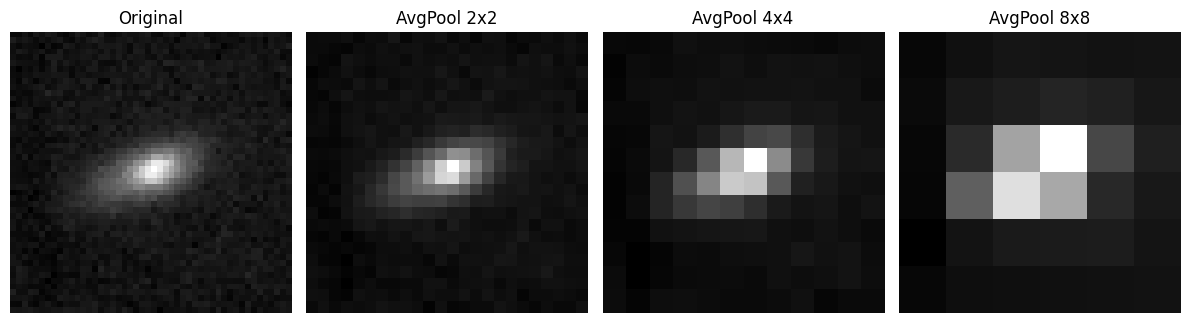

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Function to apply AvgPool2d at different scales and plot results
def plot_avg_pooled_images(image, scales=[2, 4, 8]):
    fig, axes = plt.subplots(1, len(scales) + 1, figsize=(12, 4))

    # Original image (assumed grayscale)
    image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims (1,1,H,W)
    
    # Plot original image
    axes[0].imshow(image.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")

    scaled_images = {}

    # Apply pooling at different scales
    for i, scale in enumerate(scales):
        avg_pool = nn.AvgPool2d(scale, scale)  # Pooling layer
        pooled_image = avg_pool(image).squeeze(0).squeeze(0)  # Apply pooling

        scaled_images[scale] = pooled_image
        
        # Plot pooled image
        axes[i + 1].imshow(pooled_image.cpu().numpy(), cmap='gray')
        axes[i + 1].set_title(f"AvgPool {scale}x{scale}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    return scaled_images

# Convert RGB image to grayscale (Galaxy Image)
galaxy_image = torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device))

# Call the function to visualize AvgPool2d results
scaled_images = plot_avg_pooled_images(galaxy_image)

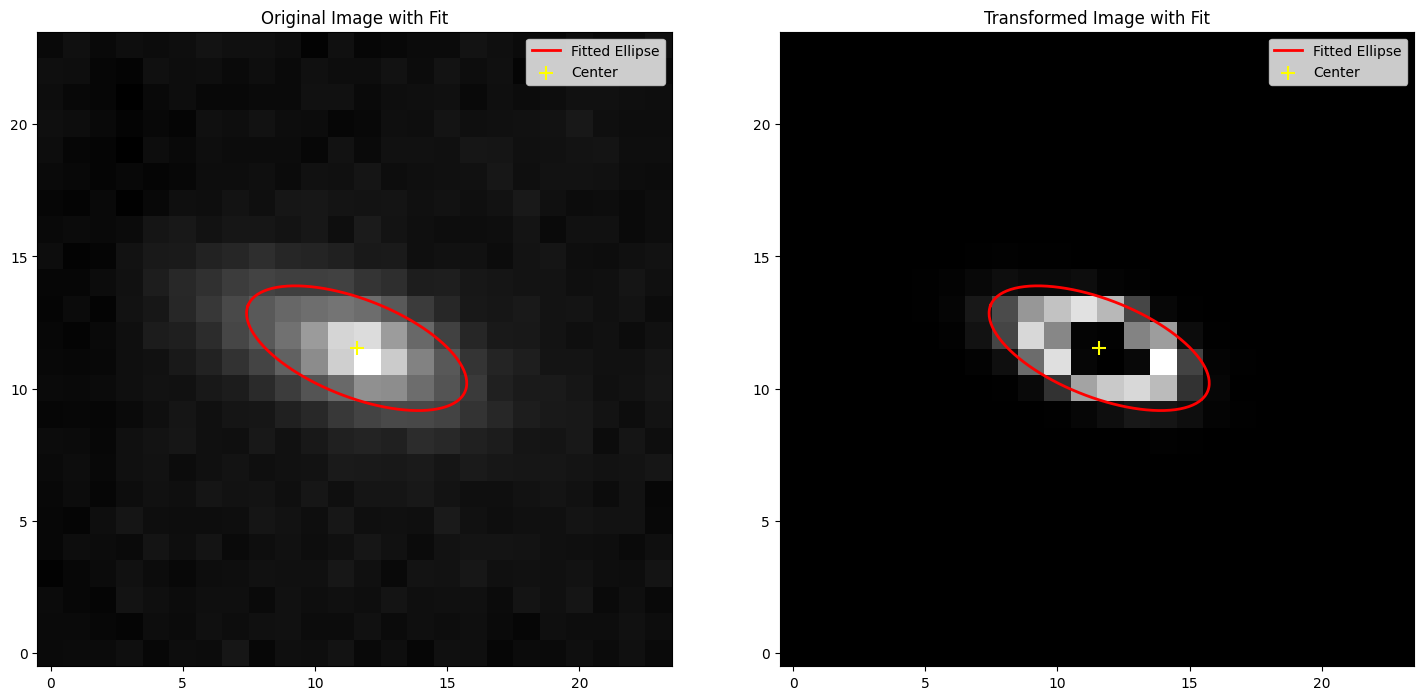

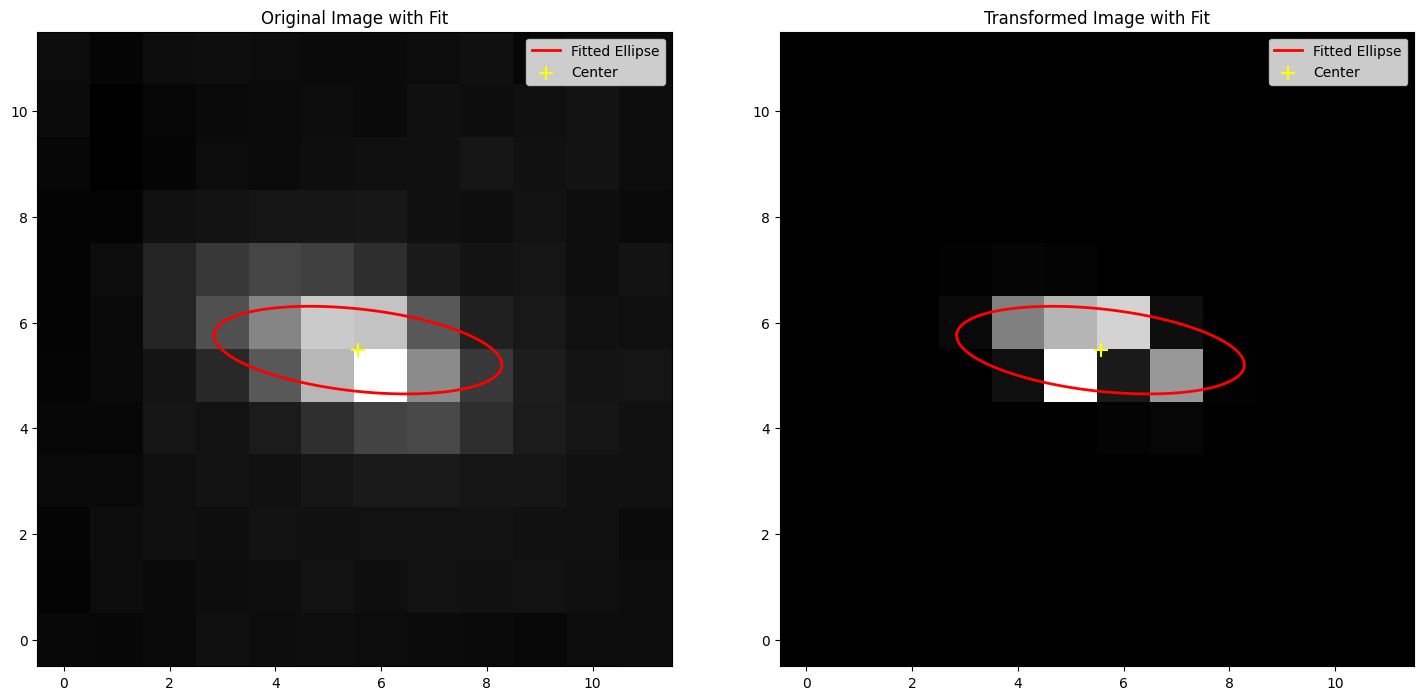

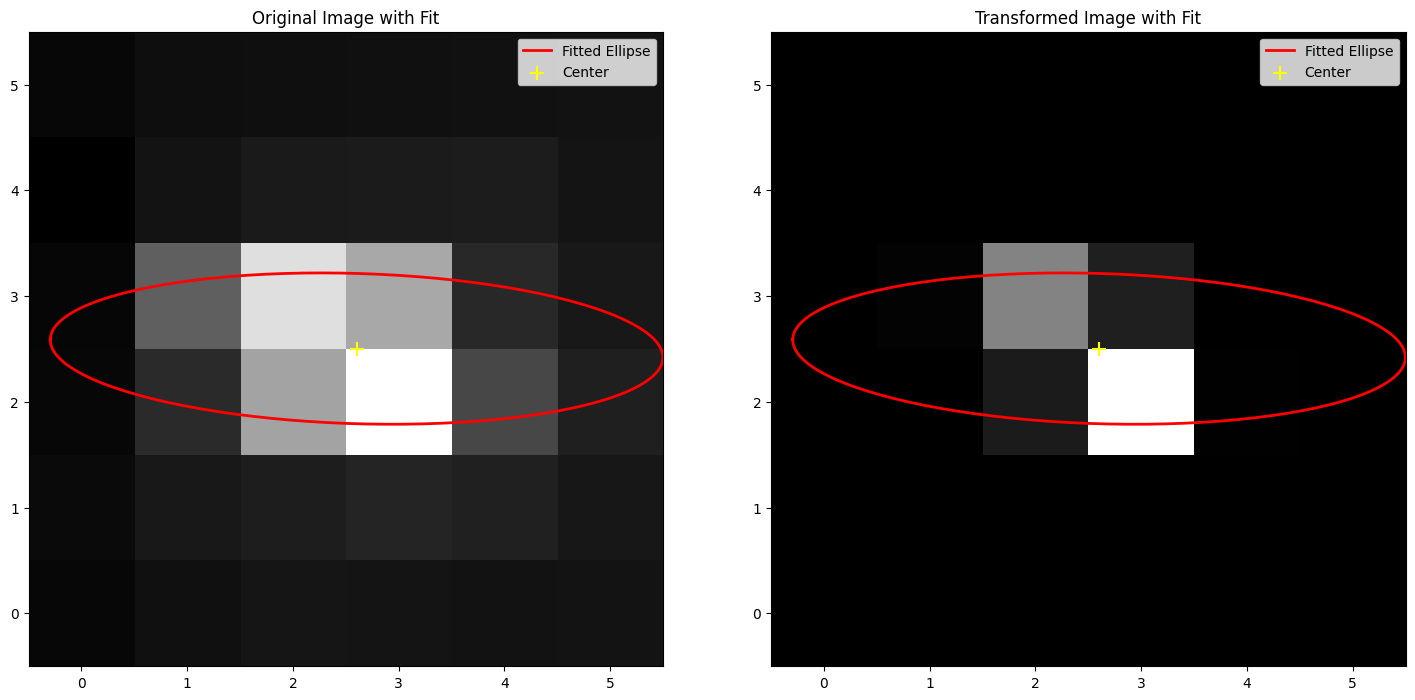

In [15]:
for scale, img in scaled_images.items():
    params, fig = process_and_fit_galaxy(img)
    plt.show()